In [23]:
%matplotlib inline
import numpy as np
import pandas as pd
#用來分析股市中的各種指數
import talib

In [24]:
dataset = pd.read_csv('2330.TW.csv')
#丟棄數據中的缺失值
dataset = dataset.dropna()
dataset = dataset[['Open', 'High', 'Low', 'Close']]


dataset['H-L'] = dataset['High'] - dataset['Low']
dataset['O-C'] = dataset['Close'] - dataset['Open']
#3天移動平均線
dataset['3day MA'] = dataset['Close'].shift(1).rolling(window = 3).mean()
dataset['10day MA'] = dataset['Close'].shift(1).rolling(window = 10).mean()
dataset['30day MA'] = dataset['Close'].shift(1).rolling(window = 30).mean()
#五天之標準差
dataset['Std_dev']= dataset['Close'].rolling(5).std()
#相對強弱指標
dataset['RSI'] = talib.RSI(dataset['Close'].values, timeperiod = 9)
#威廉指標
dataset['Williams %R'] = talib.WILLR(dataset['High'].values, dataset['Low'].values, dataset['Close'].values, 7)
#與前一天比對 股票是否有漲幅
dataset['Price_Rise'] = np.where(dataset['Close'].shift(-1) > dataset['Close'], 1, 0)

dataset = dataset.dropna()

X = dataset.iloc[:, 4:-1]
y = dataset.iloc[:, -1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [25]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
#輸出為1個
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.add(Dropout(0.2))
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
894/894 [==============================] - 0s 364us/step - loss: 0.2997 - acc: 0.5056
Epoch 2/100
894/894 [==============================] - 0s 71us/step - loss: 0.2999 - acc: 0.5369
Epoch 3/100
894/894 [==============================] - 0s 70us/step - loss: 0.2975 - acc: 0.5436
Epoch 4/100
894/894 [==============================] - 0s 70us/step - loss: 0.2932 - acc: 0.5347
Epoch 5/100
894/894 [==============================] - 0s 71us/step - loss: 0.3043 - acc: 0.5570
Epoch 6/100
894/894 [==============================] - 0s 69us/step - loss: 0.3030 - acc: 0.5235
Epoch 7/100
894/894 [==============================] - 0s 69us/step - loss: 0.2889 - acc: 0.5615
Epoch 8/100
894/894 [==============================] - 0s 71us/step - loss: 0.2884 - acc: 0.5716
Epoch 9/100
894/894 [==============================] - 0s 70us/step - loss: 0.2909 - acc: 0.5570
Epoch 10/100
894/894 [==============================] - 0s 70us/step - loss: 0.2913 - acc: 0.5459
Epoch 11/100
894/894 [======

894/894 [==============================] - 0s 70us/step - loss: 0.2793 - acc: 0.6253
Epoch 85/100
894/894 [==============================] - 0s 70us/step - loss: 0.2870 - acc: 0.6063
Epoch 86/100
894/894 [==============================] - 0s 70us/step - loss: 0.2637 - acc: 0.6264
Epoch 87/100
894/894 [==============================] - 0s 70us/step - loss: 0.2708 - acc: 0.6286
Epoch 88/100
894/894 [==============================] - 0s 69us/step - loss: 0.2653 - acc: 0.6443
Epoch 89/100
894/894 [==============================] - 0s 69us/step - loss: 0.2659 - acc: 0.6398
Epoch 90/100
894/894 [==============================] - 0s 69us/step - loss: 0.2558 - acc: 0.6387
Epoch 91/100
894/894 [==============================] - 0s 69us/step - loss: 0.2649 - acc: 0.6544
Epoch 92/100
894/894 [==============================] - 0s 69us/step - loss: 0.2560 - acc: 0.6588
Epoch 93/100
894/894 [==============================] - 0s 69us/step - loss: 0.2655 - acc: 0.6521
Epoch 94/100
894/894 [===========

In [26]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

dataset['y_pred'] = np.NaN
dataset.iloc[(len(dataset) - len(y_pred)):,-1:] = y_pred
trade_dataset = dataset.dropna()

trade_dataset['Tomorrows Returns'] = 0.
trade_dataset['Tomorrows Returns'] = np.log(trade_dataset['Close']/trade_dataset['Close'].shift(1))
trade_dataset['Tomorrows Returns'] = trade_dataset['Tomorrows Returns'].shift(-1)

trade_dataset['Strategy Returns'] = 0.
trade_dataset['Strategy Returns'] = np.where(trade_dataset['y_pred'] == True, trade_dataset['Tomorrows Returns'], - trade_dataset['Tomorrows Returns'])

trade_dataset['Cumulative Market Returns'] = np.cumsum(trade_dataset['Tomorrows Returns'])
trade_dataset['Cumulative Strategy Returns'] = np.cumsum(trade_dataset['Strategy Returns'])

/home/gtx1080/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/gtx1080/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/gtx1080/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

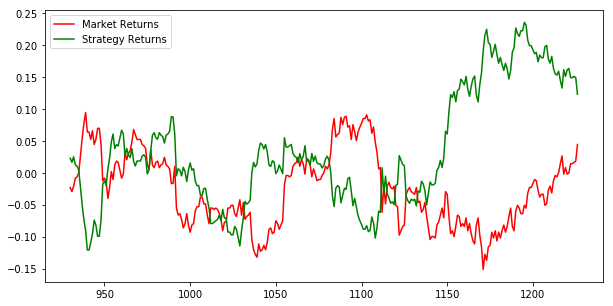

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(trade_dataset['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(trade_dataset['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()